# VT2

In [47]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation

In [48]:
# Demand at t0
Dt0 = 22561132
# Steptime in Years
dt = 1
# Time Horizon of Forecasts in Steptime
Fth = 20
# Number of Forecasts
Forecasts = 1

# Parameters
mu = 0.042754330256447565
sigma = 0.05813761525452841

### Plotting the Scenarios

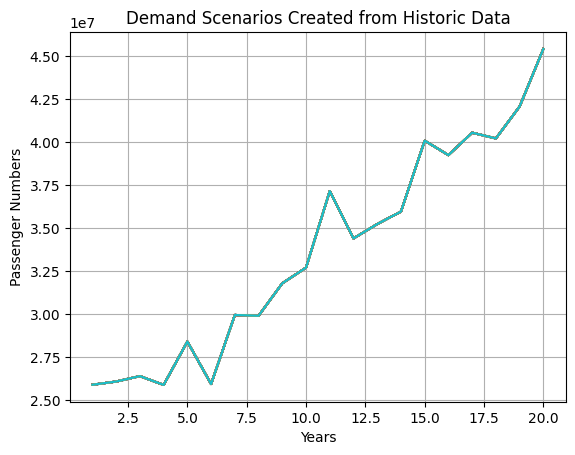

<Figure size 640x480 with 0 Axes>

In [49]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(mu, sigma, Dt0, dt, Fth, Forecasts)

# Round values up for further Calculation
D = np.ceil(Scenarios)
# print(D)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Fth,
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

# print(np.shape(Scenarios))
# print(Scenarios)

Geometric Brownian motion Formula

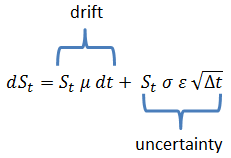

## Estimation of Dockstand Demand

In [50]:
# Percentage of Pax using Dock Stands rather than Bus Gates
p_dock = 0.8
# Percentage of Pax travelling within Schengen Area
p_schengen = 0.8
# Percentage of Pax travelling from Dock
p_Dok_A_B = 0.5
# average number of passengers carried per air traffic movement
PAXATM = 114

# Demand at design Hour
D_per_hour = D / (365 * 17)

# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM

# print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

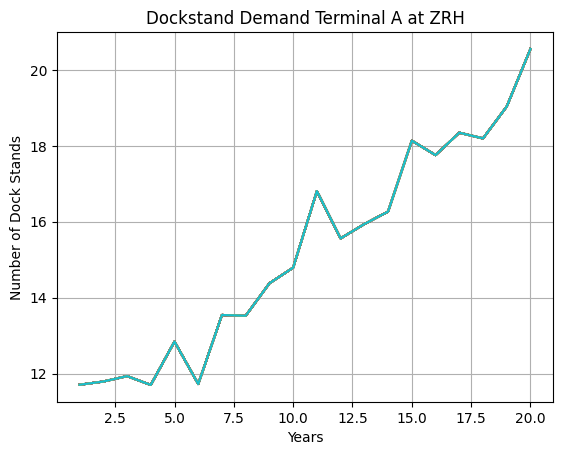

<Figure size 640x480 with 0 Axes>

In [51]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    d,
    Fth,
    True,
    "Dockstand Demand Terminal A at ZRH",
    "Number of Dock Stands",
    30,
)

## Calulation of the NPV

In [52]:
def Revenue(K, D, r_k, r_D):
    """_summary_

    Args:
        K (_type_): _description_
        D (_type_): _description_
        r_k (_type_): _description_
        r_D (_type_): _description_
    """
    R = K * r_k + D * r_D
    return R


def Cost(K, D, d, EoS, ci_K, delta_K0, h, co_D, co_K):
    """_summary_

    Args:
        K (_type_): _description_
        D (_type_): _description_
        d (_type_): _description_
        EoS (_type_): _description_
        ci_K (_type_): _description_
        delta_K0 (_type_): _description_
        h (_type_): _description_
        co_D (_type_): _description_
        co_K (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Creation of a Capacity Change Vector
    delta_K0 = np.diff(K)
    # Setting the initial Value of the Change Vector to Zero
    delta_K = np.insert(delta_K0, 0, 0)

    # Penalty Cost
    cp = 100
    # Calculate the Difference Matrix
    diff = D - K
    # Create an Index Matrix with the Condition for undercapacity
    undercapacity = np.greater(diff, 0).astype(int)

    C = (
        ((ci_K * np.abs(delta_K) ** EoS) / h)
        + (co_D * D + co_K * K)
        + undercapacity * cp
    )

    return C


def NPV_calculation(Revenue, Cost, discount):
    """
    Args:
        Revenue (_type_): _description_
        Cost (_type_): _description_
    """
    t = np.arange(0, Fth, dt)
    Profit = Revenue - Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    return NPV

In [53]:
th = 1000000  # Throughput Capacity per Unit of Capacity
r_D = 1  # Revenues per Unit of Demand per Period
r_K = 0.03  # Revenues per Unit of Capacity per Period
r_K_rent = 0.03  # Rental Revenues per Unit of Capacity per Period
co_K = 0.5  # Operational costs per unit of capacity per period
co_D = 0.5  # Operational cost per unit of demand per period
ci_K = 10  # Installation cost per unit of capacity
discount = 0.05  # Discount factor
EoS = 0.85  # EoS factor
delta_K0 = 0
h = 1

# Definition of a Capacity Vector
K_rounded = np.array(
    [25, 25, 25, 25, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50]
)

D_rounded = np.ceil(D / 1000000)

Rev = Revenue(K_rounded, D_rounded, r_K, r_D)

Cos = Cost(K_rounded, D_rounded, d, EoS, ci_K, delta_K0, h, co_D, co_K)
# print(Cos)

NPV1 = NPV_calculation(Rev, Cos, discount)
print(NPV1)

ENPV = sum(NPV1)
# print("ENPV: ", ENPV)

[-555.96424167]


### Stopping the Runtime

In [54]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 0.454146146774292
